![image](fluke_definition.png)

# Add Watermark

In [1]:
import numpy as np
import pandas as pd

In [2]:
DATA_URI = "https://raw.githubusercontent.com/AlessandroGianfelici/danish_reviews_dataset/master/raw_data.txt"

In [3]:
dataf = pd.read_csv(DATA_URI, usecols=["review_text", "review_stars"])
dataf.sample(3)

,review_text,review_stars
35971,"Dette casino er under alt kritik, de snyder de...",1
22515,Jeg har brugt skinnerup rammer flere gange nu ...,5
29247,Alm. Brand bank har serviceniveau som (discoun...,1


In [4]:
(dataf
     .groupby(by=["review_stars"])
     .nunique()
     .sort_values(by="review_text", ascending=False)
     .rename(columns={"review_text": "review_count"})
     
)

,review_count
review_stars,
5,27945
1,8437
4,3170
2,1428
3,1172


In [5]:
(dataf
     .assign(sentiment = np.where(dataf["review_stars"].gt(3), 1, 0))
     .sample(10, random_state=42)
)

,review_text,review_stars,sentiment
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1
6194,"nem hjemmeside, gode priser og hurtig levering",5,1
35684,"Har købt nærmest alt indenfor Bitz, da vi syne...",1,0
27361,Det var lige i skabet uden problemer. Super se...,5,1
35906,På forsiden af ugens reklame kunne man se at d...,2,0
21593,cpsms.dk leverer virkelig varen til en rigtig ...,5,1
26842,Det let at bestille og det hele godkendt inden...,5,1
14782,Super service og en rigtig god snak,5,1
11878,"God service og hurtig levering, jeg er fuldti...",5,1
6237,Top glasses fast delivery,5,1


In [6]:
datat = (dataf
     .assign(sentiment = np.where(dataf["review_stars"].gt(3), 1, 0))
     # .sample(10, random_state=42)
)

In [7]:
RANDOM_STATE = 42
(datat
     .assign(sentiment = np.where(dataf["review_stars"].gt(3), 1, 0))
     .sample(100, random_state=RANDOM_STATE)
     .index
)

Int64Index([19150,  6194, 35684, 27361, 35906, 21593, 26842, 14782, 11878,
             6237,  6366,  3933, 29534, 18636, 37134, 24775, 37485, 40922,
             7175, 41691, 27394, 43722, 41440,  9060, 33017, 37800,  6234,
            33131,  6244, 31033, 18094, 18491,   343, 11029, 33301, 19858,
             8541, 33348, 38990, 43832,   884,  2189, 33357, 42644, 11260,
            39990, 32610,  2746, 35265, 23420, 17792,   116, 13267, 42476,
            33393, 23068, 33157, 14600, 42026, 13956, 27984, 18578, 21954,
            12824, 11601, 24128, 31151, 22795, 37287, 14831, 32553, 15220,
            39947, 38222,  5525, 43567, 36585, 29395, 20196, 34174, 16504,
            12006, 23679,  4165,  4859,  3858, 19227, 32277, 23076, 26084,
             1673,  9162, 25704, 43924, 30777, 30827, 40119, 18237, 41948,
            17649],
           dtype='int64')

In [8]:
test_data_index = (datat
     .sample(100, random_state=RANDOM_STATE)
     .index
)

In [9]:
validation_data = datat.loc[test_data_index]

In [10]:
data = datat[~datat.index.isin(test_data_index)]

In [11]:
data.sample(5, random_state=42)

,review_text,review_stars,sentiment
10708,3. gang jeg leaser hos BMC. Intet negativt at ...,5,1
8164,Har ringet til jer 5 gange INDE i telefon tide...,4,1
19599,Vi har aldrig problemer med noget af det YouSe...,5,1
2533,Fuldt ud tilfreds!\n\nJeg har bestilt varer he...,5,1
25833,Vældigt god oplevelse med indlyttende og dygti...,5,1


In [12]:
(
    data[["sentiment"]]
     .value_counts()
     .rename(index ={0: "negative", 1:"positive"})
     .to_frame(name="observations")
     
)

,observations
sentiment,
positive,32958
negative,11027


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

In [14]:
X, y = data["review_text"], data["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.9, 
                                                    random_state=42, 
                                                    stratify=y
                                                   )

In [15]:
(
    y_train.value_counts(normalize=True), 
    y_test.value_counts(normalize=True)
)

(1    0.749305
 0    0.250695
 Name: sentiment, dtype: float64,
 1    0.749261
 0    0.250739
 Name: sentiment, dtype: float64)

In [16]:
import re
def tokenizer(blob, stop_words=None, remove_digits=True):

    if stop_words is None:
        stop_words = {}
    
    blob = blob.lower()
    
     # eyes [nose] mouth | mouth [nose] eyes pattern
    emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)"
    emoticon_re = re.compile(emoticons, re.VERBOSE | re.I | re.UNICODE)
    
    text = re.sub(r'[\W]+', ' ', blob)
    
    # remove 3+ repetitive characters i.e. hellllo -> hello, jaaaa -> jaa 
    repetitions = re.compile(r'(.)\1{2,}')
    text = repetitions.sub(r'\1\1', text)
    
    # remove 2+ repetitive words e.g. hej hej hej -> hej
    
    repetitions = re.compile(r'\b(\w+)\s+(\1\s*)+\b')
    text = repetitions.sub(r'\1 ', text)
    
    
    emoji = ''.join(re.findall(emoticon_re, blob))
    
       
    # remove stopwords
    if stop_words:
        text = [word for word in text.split() if word not in stop_words]
    

    
    if remove_digits:
        text = re.sub(r'\b\d+\b', '', text)
    

    # remove extra spaces
    text = ' '.join(text.split())
    result = f'{text} {emoji}'.encode('utf-8').decode('utf-8')
       
    
    return result.split()

In [17]:
model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, ngram_range=(1,2))),
        ("clf", SGDClassifier(loss="log")),
    ] 
)

In [18]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                                 tokenizer=<function tokenizer at 0x7f635e8b4e50>)),
                ('clf', SGDClassifier(loss='log'))])

In [19]:
model.score(X_test, y_test)

0.9279381677654013

In [20]:
y_pred = model.predict(X_test)

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

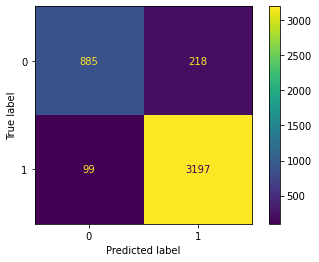

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.90      0.80      0.85      1103
    positive       0.94      0.97      0.95      3296

    accuracy                           0.93      4399
   macro avg       0.92      0.89      0.90      4399
weighted avg       0.93      0.93      0.93      4399



In [25]:
(
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .sample(10)
)

,review_text,review_stars,sentiment,score
24775,Må desværre også melde ind at man skal være yd...,1,0,0
14600,På kort varsel fik jeg skiftet bremser og klod...,5,1,1
34174,Super service. Hurtig levering,5,1,1
27361,Det var lige i skabet uden problemer. Super se...,5,1,1
21593,cpsms.dk leverer virkelig varen til en rigtig ...,5,1,1
23420,Bestilte en kjole i juni og har ikke modtaget ...,1,0,0
6194,"nem hjemmeside, gode priser og hurtig levering",5,1,1
5525,boller mange i romeriget,5,1,1
17649,Super undervisning 👍🏼👍🏼,5,1,1
6366,Der er ikke noget at klage over. Utrolig flink...,5,1,1


In [26]:
(
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
)

,review_text,review_stars,sentiment,score
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1,0
29534,Pakken kom 1 dag for sent end forventet i følg...,1,0,1
33017,"Som flere oplever, meget dårlig beskrevne effe...",1,0,1
37800,"Igennem vores boligjagt, har vi været til mang...",1,0,1
43832,Jeg gik ind på deres hjemmeside for at bestill...,5,1,0
33393,"Prisen er god, og bestilte derfor 2 par sko ti...",1,0,1
13956,"Medarbejderne knokler, der er alt for få til a...",2,0,1
37287,Jeg er fint tilfreds med POWER og deres meget ...,3,0,1
32553,"Manglende udvikling af mobilbank. JyskeBanks ""...",1,0,1
26084,Kørte på motorvejen ved Horsens og fik en fejl...,5,1,0


In [27]:
(
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1])
)

,review_text,review_stars,sentiment,score,score_probability
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1,0,0.491367
29534,Pakken kom 1 dag for sent end forventet i følg...,1,0,1,0.759036
33017,"Som flere oplever, meget dårlig beskrevne effe...",1,0,1,0.586913
37800,"Igennem vores boligjagt, har vi været til mang...",1,0,1,0.597939
43832,Jeg gik ind på deres hjemmeside for at bestill...,5,1,0,0.498246
33393,"Prisen er god, og bestilte derfor 2 par sko ti...",1,0,1,0.508159
13956,"Medarbejderne knokler, der er alt for få til a...",2,0,1,0.522922
37287,Jeg er fint tilfreds med POWER og deres meget ...,3,0,1,0.581183
32553,"Manglende udvikling af mobilbank. JyskeBanks ""...",1,0,1,0.579601
26084,Kørte på motorvejen ved Horsens og fik en fejl...,5,1,0,0.287565


In [28]:
model.named_steps["clf"].coef_[0]

array([ 0.01788492, -0.02107724, -0.00143617, ..., -0.06052219,
        0.01052879,  0.01052879])

In [29]:
model.named_steps["tfidf"].get_feature_names_out()

array(['(-:', '(8', '(8:-)', ..., 'øøvv', 'жre', 'жre medlem'],
      dtype=object)

In [30]:
explain = (
        pd
            .DataFrame({"score":model.named_steps["clf"].coef_[0]},
                       index = model.named_steps["tfidf"].get_feature_names_out()
            )
            .sort_values(by="score")
)

In [31]:
explain.head(3), explain.tail(3)

(            score
 ikke   -10.039343
 dårlig  -5.887400
 at      -3.888518,
            score
 hurtig  5.008394
 super   5.413731
 god     5.863732)

In [32]:
(
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1])
    .loc[lambda d: (d["score"].eq(0) & d["score_probability"].lt(.4))]
    # .loc[lambda d: (d["score"].eq(1) & d["score_probability"].gt(.6))]
)

,review_text,review_stars,sentiment,score,score_probability
26084,Kørte på motorvejen ved Horsens og fik en fejl...,5,1,0,0.287565


In [33]:
message = (
    validation_data
    .assign(score = lambda d: model.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1])
    .loc[lambda d: (d["score"].eq(0) & d["score_probability"].lt(.4))]
    # .loc[lambda d: (d["score"].eq(1) & d["score_probability"].gt(.6))]
)["review_text"].squeeze()

In [34]:
message

'Kørte på motorvejen ved Horsens og fik en fejl på motoren. Jeg ringede og de lovede akut at sætte en tester på for at udlæse fejl. Det gjorde de, fin service, men desværre blokerede en leverandørlastbil så bilen ikke kunne komme ud af værkstedet. Det var jo ikke RAF’s skyld, men fordi jeg måtte vente 20-25 minutter ønskede de ikke betaling. Her kommer jeg gerne igen.'

In [35]:
explain[explain.index.isin(pd.Index(tokenizer(message)))]

,score
ikke,-10.039343
at,-3.888518
men,-3.881216
på,-3.448895
de,-2.972997
for,-2.724729
af,-1.854285
så,-1.607773
det,-1.189826
desværre,-1.179965


In [36]:
model.named_steps["clf"].intercept_[0]

1.514685415068535

In [37]:
model.predict_proba([""])

array([[0.18024545, 0.81975455]])

In [38]:
# From the example, I can deduce that input is easy for human but will be a challenge for any model

## Neither Hisia (trained with more similiar examples) or Transformer model pass the test

In [38]:
import sys
!{sys.executable} -m pip install hisia --quiet

In [39]:
import hisia
hisia.Hisia(message)

Sentiment(sentiment=negative, positive_probability=0.402, negative_probability=0.598)

![transformers](transformer.png "Not even Transformers")

In [40]:
## Just curious
# hisia.Hisia("det er ikke ok")

# model.predict_proba(["det er ikke ok"]) # 0 - negative, 1 - positive

In [43]:
# This led us to the next. What predictions we might have got correct by fluke?

In [43]:
LOWER_BOUND, UPPER_BOUND = 0.35, 0.65
(
    validation_data
    .assign(score_probability = lambda d: model.predict_proba(d["review_text"])[:, 1],
            score = lambda d: np.where(d["score_probability"].gt(.5), 1, 0))
    .loc[lambda d: (d["score_probability"].gt(LOWER_BOUND) & d["score_probability"].lt(UPPER_BOUND))]
    .sort_values(by="score_probability")
)

,review_text,review_stars,sentiment,score_probability,score
343,Den ene af to bøger ankom med tydelige ‘slåede...,2,0,0.369196,0
15220,"Jeg har handlet af to omgange, gennem butikken...",3,0,0.422429,0
35265,Færdig med at vente 🙂\nFinder min oprindelige ...,1,0,0.456847,0
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1,0.491367,0
43832,Jeg gik ind på deres hjemmeside for at bestill...,5,1,0.498246,0
41440,Skulle have en Office licens. \nSmartworld hav...,5,1,0.504982,1
33393,"Prisen er god, og bestilte derfor 2 par sko ti...",1,0,0.508159,1
13956,"Medarbejderne knokler, der er alt for få til a...",2,0,0.522922,1
25704,Yousee er en pengemaskine og tænker ikke på an...,1,0,0.525702,1
32553,"Manglende udvikling af mobilbank. JyskeBanks ""...",1,0,0.579601,1


In [44]:
# before diving in, let elimate the problem with models

from sklearn.ensemble import ExtraTreesClassifier

In [48]:
et = Pipeline(
    [
        ("tfidf", TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, ngram_range=(1,2))),
        ("clf", ExtraTreesClassifier(random_state=42, n_jobs=-1)),
    ] 
).fit(X_train, y_train)

print(classification_report(y_test, et.predict(X_test), target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.91      0.73      0.81      1103
    positive       0.92      0.97      0.94      3296

    accuracy                           0.91      4399
   macro avg       0.91      0.85      0.88      4399
weighted avg       0.91      0.91      0.91      4399



In [49]:
LOWER_BOUND, UPPER_BOUND = 0.35, 0.65
(
    validation_data
    .assign(score_probability = lambda d: et.predict_proba(d["review_text"])[:, 1],
            score = lambda d: np.where(d["score_probability"].gt(.5), 1, 0))
    .loc[lambda d: (d["score_probability"].gt(LOWER_BOUND) & d["score_probability"].lt(UPPER_BOUND))]
    .sort_values(by="score_probability")
)

,review_text,review_stars,sentiment,score_probability,score
35906,På forsiden af ugens reklame kunne man se at d...,2,0,0.36,0
36585,Bestilte støvsugerslange til min miele\nInden ...,1,0,0.39,0
35684,"Har købt nærmest alt indenfor Bitz, da vi syne...",1,0,0.41,0
26084,Kørte på motorvejen ved Horsens og fik en fejl...,5,1,0.49,0
33393,"Prisen er god, og bestilte derfor 2 par sko ti...",1,0,0.50,0
30777,Blev kontaktet af lotto 365 om jeg vil med i e...,1,0,0.51,1
24775,Må desværre også melde ind at man skal være yd...,1,0,0.52,1
343,Den ene af to bøger ankom med tydelige ‘slåede...,2,0,0.54,1
27984,Rigtig venlig kundeservice.\nRåd og vejledning...,5,1,0.55,1
37800,"Igennem vores boligjagt, har vi været til mang...",1,0,0.58,1


In [96]:
import time
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB

In [97]:
classifiers = {
    "Perceptron": Perceptron(n_jobs=-1),
    "NBMultinomial": MultinomialNB(alpha=1e-2,),
    "PassiveAggressive": PassiveAggressiveClassifier(n_jobs=-1),
    "LogisticRegression": LogisticRegressionCV(cv=5, n_jobs=-1, max_iter=5e3), #takes long to train
}

trained_classifiers = {}

for clf, model in classifiers.items():
    print(f"Training {clf}")
    start_time = time.perf_counter()
    m = Pipeline(
                [
                    ("tfidf", TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, ngram_range=(1,2))),
                    ("clf", model),
                ] 
        ).fit(X_train, y_train)
    
    print(f"Training completed in {time.perf_counter() - start_time : .2f} seconds")
    
    
    print(classification_report(y_test, m.predict(X_test), target_names=["negative", "positive"]))
    trained_classifiers[clf] = m
    
    
    

Training Perceptron
Training completed in  6.28 seconds
              precision    recall  f1-score   support

    negative       0.92      0.89      0.90      1103
    positive       0.96      0.97      0.97      3296

    accuracy                           0.95      4399
   macro avg       0.94      0.93      0.94      4399
weighted avg       0.95      0.95      0.95      4399

Training NBMultinomial
Training completed in  6.28 seconds
              precision    recall  f1-score   support

    negative       0.85      0.95      0.90      1103
    positive       0.98      0.94      0.96      3296

    accuracy                           0.94      4399
   macro avg       0.92      0.95      0.93      4399
weighted avg       0.95      0.94      0.95      4399

Training PassiveAggressive
Training completed in  6.37 seconds
              precision    recall  f1-score   support

    negative       0.92      0.92      0.92      1103
    positive       0.97      0.97      0.97      3296

    

In [82]:
# poetry add torch --platform linux --python "^3.8" -vvv

In [90]:
LOWER_BOUND, UPPER_BOUND = 0.35, 0.65
(
    validation_data
    .assign(score_probability = lambda d: trained_classifiers["LogisticRegression"].predict_proba(d["review_text"])[:, 1],
            score = lambda d: np.where(d["score_probability"].gt(.5), 1, 0))
    .loc[lambda d: (d["score_probability"].gt(LOWER_BOUND) & d["score_probability"].lt(UPPER_BOUND))]
    .sort_values(by="score_probability")
)

,review_text,review_stars,sentiment,score_probability,score
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1,0.474867,0


In [93]:
lr = trained_classifiers["LogisticRegression"]
(
    validation_data
    .assign(score = lambda d: lr.predict(d["review_text"]))
    .loc[lambda d: d["sentiment"].ne(d["score"])]
    .assign(score_probability = lambda d: lr.predict_proba(d["review_text"])[:, 1])
    # .loc[lambda d: (d["score"].eq(0) & d["score_probability"].lt(.45))]
    # .loc[lambda d: (d["score"].eq(1) & d["score_probability"].gt(.6))]
)

,review_text,review_stars,sentiment,score,score_probability
19150,Dejligt man kan købe den rigtig størrelse når ...,5,1,0,0.474867
29534,Pakken kom 1 dag for sent end forventet i følg...,1,0,1,0.999016
41440,Skulle have en Office licens. \nSmartworld hav...,5,1,0,0.323868
37800,"Igennem vores boligjagt, har vi været til mang...",1,0,1,0.970020
37287,Jeg er fint tilfreds med POWER og deres meget ...,3,0,1,0.995818
26084,Kørte på motorvejen ved Horsens og fik en fejl...,5,1,0,0.018770


In [95]:
lr.predict_proba([message])

array([[0.98122975, 0.01877025]])